# demo of making linking tree
1. Make a link composer by read phase/mask tif, or phase/mask folder
 - it extracted a set of cells
 - it gives tools and data could used for link
2. Ask Composer for an empty tree. Fill in the linking graph
3. Show lineage 


In [1]:
import sys
import os

# Append the directory of the module to the Python path
sys.path.append("/Users/sherryyang/Projects/super-segger-toolkit/superseggertoolkit")

In [2]:
from cell import Cell
from link_composer import LinkComposer
import cells_extractor 
import visualizer
from cell_event import CellEvent, CellDefine, Cell

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import matplotlib.patches as patches
import networkx as nx

**LinkComposer is a manager/handle of one data**
- it make each mask in a Cell class (fame, mask label, polygon)
- for those cannot be fit into a polygon, put them into a error list, you could see all error mask by visualizer.plot_error_masks(mask,error)
- if you work on a certain data, no matter how many linker you tried, you only need one composer
1. it can read assignment files
2. it can provide a empty tree with all cells node inside, which could be used to fill in

In [4]:
mask_folder = "/Users/sherryyang/Documents/wiggins-lab/data/1023/xy5/masks/*.png"
phase_folder = "/Users/sherryyang/Documents/wiggins-lab/data/1023/xy5/phase/*c1.tif"
composer = LinkComposer.read_folder(mask_folder=mask_folder, phase_folder=phase_folder)

In [5]:
composer.error

[]

In [6]:

cells_list = list(composer.cells)
cells_list.sort()
for cell in cells_list[:2]:
    print(cell)

Cell: frame_0, label_1
Cell: frame_1, label_1


**Linking cells by adding edge on a graph**
- you could use Graph buildin function to G.add_edge(Cell(frame, label), Cell(frame, label)), but it will automatically add node if the node is not in graph
- or use composer(G, cell1, cell2), it make sure the cell1, cell2 is in the data

In [7]:
G_new = composer.make_new_dircted_graph()

In [8]:
composer.link(G_new,  Cell(107, 11), Cell(117, 60))

In [9]:
G_new.add_edge(Cell(117, 60), Cell(129, 93))
G_new.add_edge(Cell(117, 60), Cell(129, 11))

**Make a lineage**
- default to zoom in on the edges on the tree
- statstic information on the top right:
    - COverage rate means how many nodes be linked on your linking graph
    - ghoest means the node not be linked on edge
    - irregular death is the death before last frame.

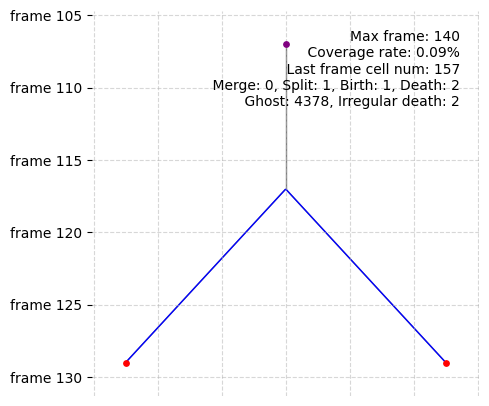

In [10]:
# make a lineage for your new graph, the default setting zoom in on node and edges your tree has
# figsize is not needed, default to (10,10)
visualizer.quick_lineage(G_new, figsize=(5,5))

To zoom out: globally=true
- Add "globally == true", make zoom out version of your lineage

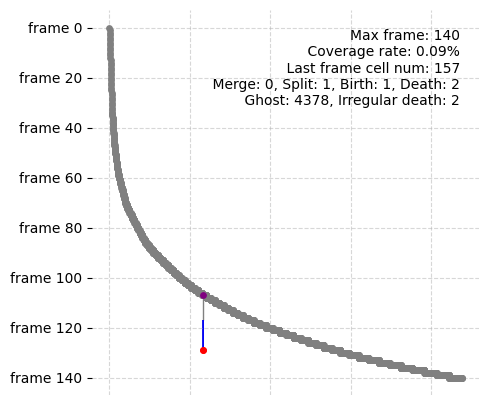

In [11]:
# Most of nodes is not linked, thus cannot put nodes in T1 frame under the nodes in T0 frame 
#so it every unlinked detected nodes/cells in a frame be put in a new position on right on lineage
visualizer.quick_lineage(G_new, globally = True, figsize=(5,5))

**More possible linking and lineage overview**

In [12]:
composer.link(G_new,  Cell(99, 7), Cell(124, 64))

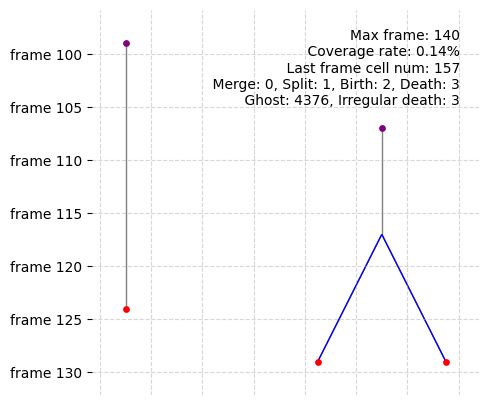

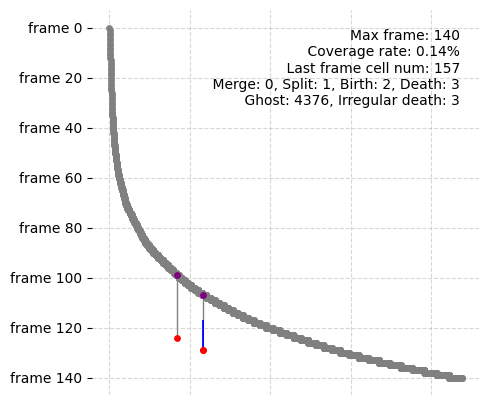

In [13]:
visualizer.quick_lineage(G_new, figsize=(5, 5))
visualizer.quick_lineage(G_new, globally=True, figsize=(5, 5))

**A quick assignment loop**

In [14]:
G = composer.make_new_dircted_graph()
dict = composer.cells_frame_dict
sorted_frame = sorted(dict)

In [15]:
# simple assign to best IoU
for i in range(1, len(sorted_frame)):
    source_frame = dict[sorted_frame[i-1]]
    target_frame =  dict[sorted_frame[i]]
    for cell in target_frame:
        max_IoU = 0
        best_candidate = None
        for cell_candicate in source_frame:
            intersect = cell.polygon.intersection(cell_candicate.polygon).area 
            union = cell.polygon.union(cell_candicate.polygon).area 
            IoU = intersect * 1.0 / union
            if IoU  > max_IoU:
                max_IoU  = IoU
                best_candidate = cell_candicate
        if best_candidate is not None:
            G.add_edge(best_candidate, cell)

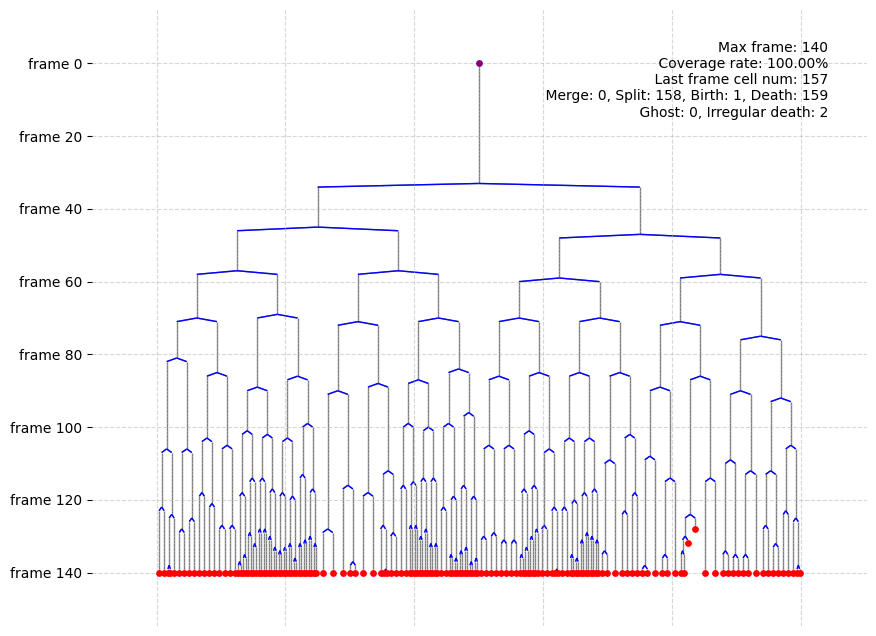

In [16]:
# notice no figsize, it's default size of quick lineage
visualizer.quick_lineage(G)

In [17]:
# simply choice to merge by IoU
for i in range(1, len(sorted_frame)):
    source_frame = dict[sorted_frame[i-1]]
    target_frame =  dict[sorted_frame[i]]
    for cell in source_frame:
        if G.out_degree(cell) == 0:
            max_IoU = 0
            best_candidate = None
            for cell_candicate in target_frame:
                intersect = cell.polygon.intersection(cell_candicate.polygon).area 
                union = cell.polygon.union(cell_candicate.polygon).area 
                IoU = intersect * 1.0 / union
                if IoU  > max_IoU:
                    max_IoU  = IoU
                    best_candidate = cell_candicate
            if best_candidate is not None:
                G.add_edge(cell, best_candidate)

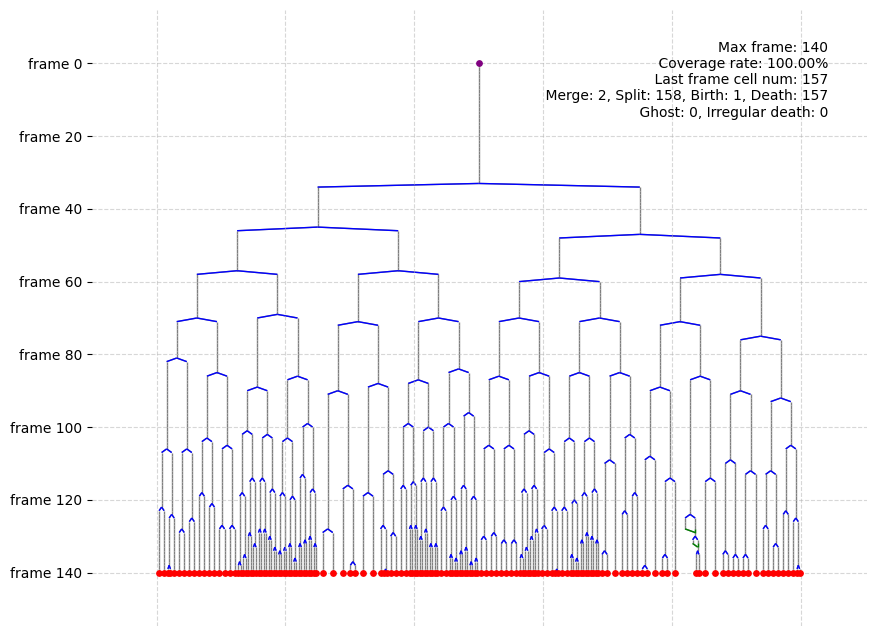

In [18]:
visualizer.quick_lineage(G, globally=True)